## Pho bert

In [1]:
# Cell 1: Import & cấu hình thiết bị (GPU/FP16)

import os, sys, gc, math, pathlib, shutil
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

from transformers import AutoTokenizer, AutoModel

print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Thiết bị & dtype (FP16 nếu có GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_fp16 = torch.cuda.is_available()
dtype = torch.float16 if use_fp16 else torch.float32
print("Dtype dùng:", dtype)

# Thư mục output
OUT_DIR = "outputs_phobert"
os.makedirs(OUT_DIR, exist_ok=True)

/home/thinhbq/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python: 3.12.2
PyTorch: 2.8.0+cu128
CUDA available: True
GPU: NVIDIA L4
Dtype dùng: torch.float16


In [1]:
import pandas as pd

# CSV_PATH = "/home/thinhbq/huy/social_networking/pho_bert/description_phobert(1).csv"  
CSV_PATH="/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/project_2A/description_phobert(1).csv"

df = pd.read_csv(CSV_PATH)

print("Cột:", df.columns.tolist())
print("Tổng dòng gốc:", len(df))

df["category_name"] = df["category_name"].fillna("unknown").astype(str)
df["description"]   = df["description"].fillna("").astype(str)

n_na        = df["description"].isna().sum()
n_empty     = (df["description"] == "").sum()
n_ws_only   = df["description"].str.strip().eq("").sum()

print(f"NaN: {n_na} | empty '': {n_empty} | whitespace-only: {n_ws_only}")

n_dups_desc = df.duplicated(subset=["description"]).sum()
print(f"Số dòng trùng mô tả (không tính dòng đầu tiên): {n_dups_desc}")

ex_ws = df[df["description"].str.strip().eq("")].head(5)
if len(ex_ws):
    print("\nVí dụ mô tả trắng/rỗng:")
    display(ex_ws)

df_keep = df[df["description"].str.strip().ne("")].reset_index(drop=True)
print("\nSố dòng sau khi loại trắng:", len(df_keep))

Cột: ['category_name', 'description']
Tổng dòng gốc: 36644
NaN: 0 | empty '': 0 | whitespace-only: 0
Số dòng trùng mô tả (không tính dòng đầu tiên): 3429

Số dòng sau khi loại trắng: 36644


In [2]:
df_keep["word_count"] = df_keep["description"].str.split().apply(len)
print(df_keep["word_count"].describe())

count    36644.000000
mean       360.593440
std        273.203648
min          5.000000
25%        171.000000
50%        306.000000
75%        488.000000
max       6076.000000
Name: word_count, dtype: float64


In [3]:
total_words = df_keep["word_count"].sum()
print(f"Tổng số từ trong toàn bộ mô tả: {total_words:,}")

Tổng số từ trong toàn bộ mô tả: 13,213,586


In [3]:
import torch
from transformers import AutoTokenizer, AutoModel

MODEL_NAME = "vinai/phobert-large"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print("device:", device, "| dtype:", dtype)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModel.from_pretrained(MODEL_NAME)
model = model.to(device=device, dtype=dtype)
model.eval()


device: cuda | dtype: torch.float16


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 1024, padding_idx=1)
    (position_embeddings): Embedding(258, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      

### word-segmentation

In [4]:
import os
import py_vncorenlp

VNCORE_DIR = "/home/thinhbq/huy/social_networking/pho_bert/vncorenlp"
os.makedirs(VNCORE_DIR, exist_ok=True)
# py_vncorenlp.download_model(save_dir=VNCORE_DIR)

if "rdrsegmenter" not in globals():
    rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=VNCORE_DIR)
    print("VnCoreNLP loaded.")
else:
    print("Reusing existing rdrsegmenter (already loaded).")

def vn_word_segment(text: str) -> str:
    if not text.strip():
        return ""
    sents = rdrsegmenter.word_segment(text)
    return " ".join(sents)

df_keep["description_wseg"] = [vn_word_segment(t) for t in df_keep["description"]]

print("Ví dụ sau khi word-seg:")
print(df_keep[["description", "description_wseg"]].head(3))

df_keep.to_parquet("description_phobert_wseg.parquet", index=False)

2025-10-11 17:55:12 INFO  WordSegmenter:24 - Loading Word Segmentation model
VnCoreNLP loaded.
Ví dụ sau khi word-seg:
                                         description  \
0  loa loa sản phẩm nguyên sản phẩm nguyên cam kế...   
1  đặc điểm nổi bật đặc điểm nổi bật công nghệ ch...   
2  thông số kỹ thuật loa 3 loa di động thương hiệ...   

                                    description_wseg  
0  loa loa sản_phẩm nguyên sản_phẩm nguyên cam_kế...  
1  đặc_điểm nổi_bật đặc_điểm nổi_bật công_nghệ ch...  
2  thông_số kỹ_thuật loa 3 loa di_động thương_hiệ...  


### embeding

In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from contextlib import nullcontext

MAX_LEN = 256
BATCH_SIZE = 64

DATA_PATH = "description_phobert_wseg.parquet"
df_wseg = pd.read_parquet(DATA_PATH)
texts = df_wseg["description_wseg"].tolist()

class TextDataset(Dataset):
    def __init__(self, texts): self.texts = texts
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx): return self.texts[idx]

dataset = TextDataset(texts)

def collate_batch(batch_texts):
    return tokenizer(
        batch_texts,
        padding="max_length",      
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    num_workers=2 if device.type == "cuda" else 0,
    pin_memory=(device.type == "cuda")
)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state      
    mask = attention_mask.unsqueeze(-1).expand_as(token_embeddings).float()
    return (token_embeddings * mask).sum(1) / mask.sum(1).clamp(min=1e-9)

all_embeddings = []
model.eval()

amp_ctx = torch.autocast(device_type="cuda", dtype=dtype) if device.type=="cuda" else nullcontext()

with torch.inference_mode():
    for batch in tqdm(loader, desc="Encoding"):
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        with amp_ctx:
            outputs = model(**batch)
            emb = mean_pooling(outputs, batch["attention_mask"])
            emb = torch.nn.functional.normalize(emb, p=2, dim=1) 
        all_embeddings.append(emb.cpu().numpy())

embeddings = np.vstack(all_embeddings)
assert embeddings.shape[0] == len(df_wseg), "Số embedding không khớp số dòng metadata!"

np.save("/home/thinhbq/huy/social_networking/pho_bert/outputs_phobert/phobert_embeddings.npy", embeddings)
df_wseg.to_parquet("/home/thinhbq/huy/social_networking/pho_bert/outputs_phobert/metadata_phobert.parquet", index=False)

Encoding: 100%|██████████| 573/573 [04:55<00:00,  1.94it/s]


In [9]:
import numpy as np, pandas as pd
from pathlib import Path

OUT_DIR   = "/home/thinhbq/huy/social_networking/pho_bert/outputs_phobert"
EMB_PATH  = f"{OUT_DIR}/phobert_embeddings.npy"
META_PATH = f"{OUT_DIR}/metadata_phobert.parquet"

assert Path(EMB_PATH).exists(), EMB_PATH
assert Path(META_PATH).exists(), META_PATH

embeddings = np.load(EMB_PATH)                 
meta       = pd.read_parquet(META_PATH)        
assert embeddings.shape[0] == len(meta)

print("Embeddings:", embeddings.shape)
print("Meta:", meta.shape)

Embeddings: (36644, 1024)
Meta: (36644, 3)


### Kmean

#### Grid search tìm K

In [10]:
import numpy as np, pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

EMB_PATH = "/home/thinhbq/huy/social_networking/pho_bert/outputs_phobert/phobert_embeddings.npy"
Ks = [4, 8, 12, 16, 20, 24, 28, 30, 40, 50]

X  = np.load(EMB_PATH)
Xn = normalize(X)

rows = []
for K in Ks:
    labels = KMeans(n_clusters=K, n_init="auto", random_state=42).fit_predict(Xn)
    sil = float(silhouette_score(Xn, labels, metric="cosine"))
    rows.append((K, sil))

df_k = pd.DataFrame(rows, columns=["K","silhouette_cosine"]).sort_values("silhouette_cosine", ascending=False)
best_K = int(df_k.iloc[0]["K"])
print(df_k.to_string(index=False))
print("best_K:", best_K)

 K  silhouette_cosine
12           0.204663
16           0.194674
20           0.192583
 4           0.190894
 8           0.177111
30           0.175496
28           0.175351
24           0.173827
40           0.166742
50           0.160448
best_K: 12


#### áp dụng Kmean với K tìm được

In [12]:
from sklearn.cluster import KMeans
import numpy as np

km = KMeans(n_clusters=best_K, n_init="auto", random_state=42).fit(Xn)
labels = km.labels_

uniq, cnt = np.unique(labels, return_counts=True)
print("best_K:", best_K, "| n_clusters:", len(uniq))
for k, c in zip(uniq, cnt):
    print(f"cluster {k}: {c}")

best_K: 12 | n_clusters: 12
cluster 0: 1757
cluster 1: 1418
cluster 2: 2986
cluster 3: 2504
cluster 4: 3488
cluster 5: 2251
cluster 6: 4104
cluster 7: 3327
cluster 8: 4298
cluster 9: 1842
cluster 10: 2939
cluster 11: 5730


#### đánh giá trong trường hợp không có nhãn

In [ ]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import os

EVAL_PATH = "/home/thinhbq/huy/social_networking/pho_bert/clustering/evaluation_phobert.csv"

sil = float(silhouette_score(Xn, labels, metric="cosine"))
dbi = float(davies_bouldin_score(Xn, labels))
ch  = float(calinski_harabasz_score(Xn, labels))

print(f"[Unsupervised] Silhouette(cosine)={sil:.4f} | DBI={dbi:.4f} | CH={ch:.2f}")

record = pd.DataFrame([{
    "model": "KMeans",
    "metric": "cosine",
    "K": best_K,
    "type": "unsupervised",
    "silhouette_cosine": sil,
    "DBI": dbi,
    "CH": ch,
    "NMI": None,
    "ARI": None,
    "Purity": None
}])

if os.path.exists(EVAL_PATH):
    old = pd.read_csv(EVAL_PATH)
    df_out = pd.concat([old, record], ignore_index=True)
else:
    df_out = record

df_out.to_csv(EVAL_PATH, index=False)

[Unsupervised] Silhouette(cosine)=0.2047 | DBI=2.2994 | CH=2418.46


#### đánh giá trong trường hợp có nhãn

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
import os

META_PATH = "/home/thinhbq/huy/social_networking/pho_bert/outputs_phobert/metadata_phobert.parquet"
EVAL_PATH = "/home/thinhbq/huy/social_networking/pho_bert/clustering/evaluation_phobert.csv"

df_meta = pd.read_parquet(META_PATH)
y_true = LabelEncoder().fit_transform(df_meta["category_name"].astype(str).values)

def purity_score(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return cm.max(axis=0).sum() / cm.sum()

nmi = float(normalized_mutual_info_score(y_true, labels, average_method="arithmetic"))
ari = float(adjusted_rand_score(y_true, labels))
pur = float(purity_score(y_true, labels))

print(f"[Supervised] NMI={nmi:.4f} | ARI={ari:.4f} | Purity={pur:.4f}")

record = pd.DataFrame([{
    "model": "KMeans",
    "metric": "cosine",
    "K": best_K,
    "type": "supervised",
    "silhouette_cosine": None,
    "DBI": None,
    "CH": None,
    "NMI": nmi,
    "ARI": ari,
    "Purity": pur
}])

if os.path.exists(EVAL_PATH):
    old = pd.read_csv(EVAL_PATH)
    df_out = pd.concat([old, record], ignore_index=True)
else:
    df_out = record

df_out.to_csv(EVAL_PATH, index=False)

[Supervised] NMI=0.5477 | ARI=0.3781 | Purity=0.5329


/tmp/ipykernel_2186194/2530096801.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat([old, record], ignore_index=True)


### DBSCAN

#### Grid search

In [24]:
# DBSCAN (cosine) — Grid search chỉ theo silhouette
import numpy as np, pandas as pd
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# EMB_PATH = "/home/thinhbq/huy/social_networking/pho_bert/outputs_phobert/phobert_embeddings.npy"
EMB_PATH = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/pho_bert/outputs_phobert/phobert_embeddings.npy"
EPS_LIST = [0.003, 0.005, 0.007, 0.009, 0.011, 0.013]
MS_LIST  = [5, 8, 10, 12, 15]

X  = np.load(EMB_PATH)
Xn = normalize(X)

rows = []
for eps in EPS_LIST:
    for ms in MS_LIST:
        labels = DBSCAN(eps=eps, min_samples=ms, metric="cosine", n_jobs=-1).fit_predict(Xn)
        mask = labels != -1
        if mask.sum() >= 2 and len(np.unique(labels[mask])) >= 2:
            sil = float(silhouette_score(Xn[mask], labels[mask], metric="cosine"))
        else:
            sil = np.nan
        rows.append((eps, ms, sil, int((~mask).sum()) / len(labels)))

df = pd.DataFrame(rows, columns=["eps", "min_samples", "silhouette_cosine", "noise_frac"])
df = df.sort_values("silhouette_cosine", ascending=False, na_position="last")

print(df.head(15).to_string(index=False))

best = df.dropna(subset=["silhouette_cosine"]).iloc[0]
best_eps = float(best.eps)
best_ms  = int(best.min_samples)

print(f"\nChọn: eps={best_eps}, min_samples={best_ms} | sil={best.silhouette_cosine:.4f}")

# Fit lại với best params và in thống kê cụm
labels_best = DBSCAN(eps=best_eps, min_samples=best_ms, metric="cosine", n_jobs=-1).fit_predict(Xn)
uniq, cnt = np.unique(labels_best[labels_best != -1], return_counts=True)
noise = int((labels_best == -1).sum())
print(f"clusters={len(uniq)} | noise={noise}/{len(labels_best)} ({noise/len(labels_best):.2%})")
for k, c in zip(uniq, cnt):
    print(f"cluster {k}: {c}")

  eps  min_samples  silhouette_cosine  noise_frac
0.007           15           0.555812    0.020358
0.007           12           0.555514    0.019348
0.007           10           0.555455    0.018912
0.007            8           0.555242    0.018339
0.013            5           0.526894    0.000655
0.013           10           0.526874    0.000791
0.013            8           0.526874    0.000791
0.013           12           0.514477    0.000928
0.013           15           0.514477    0.000928
0.009           10           0.470796    0.004557
0.009            8           0.470769    0.004475
0.011           10           0.469657    0.001610
0.011            8           0.469657    0.001610
0.011            5           0.469643    0.001446
0.009            5           0.467761    0.003930

Chọn: eps=0.007, min_samples=15 | sil=0.5558
clusters=2 | noise=746/36644 (2.04%)
cluster 0: 35883
cluster 1: 15


#### Áp dụng với DBSCAN

In [5]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
import numpy as np


db = DBSCAN(eps=0.007, min_samples=15, metric="cosine", n_jobs=-1).fit(Xn)
labels = db.labels_

noise = int((labels == -1).sum())
uniq, cnt = np.unique(labels[labels != -1], return_counts=True)
print(f"eps={0.007}, min_samples={15}")
print(f"clusters={len(uniq)} | noise={noise} / {len(labels)} ({noise/len(labels):.2%})")
for k, c in zip(uniq, cnt):
    print(f"cluster {k}: {c}")

eps=0.007, min_samples=15
clusters=2 | noise=746 / 36644 (2.04%)
cluster 0: 35883
cluster 1: 15


#### đánh giá ( trong trường hợp không biết nhãn)

In [ ]:
# DBSCAN (COSINE) — Cell 3: unsupervised eval + append CSV
import pandas as pd, os
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

EVAL_PATH = "/home/thinhbq/huy/social_networking/pho_bert/clustering/evaluation_phobert.csv"

mask = (labels != -1)
if mask.sum() >= 2 and len(np.unique(labels[mask])) >= 2:
    sil = float(silhouette_score(Xn[mask], labels[mask], metric="cosine"))
    dbi = float(davies_bouldin_score(Xn[mask], labels[mask]))
    ch  = float(calinski_harabasz_score(Xn[mask], labels[mask]))
else:
    sil = dbi = ch = float("nan")

print(f"[DBSCAN-cosine | unsupervised] sil={sil:.4f} | DBI={dbi} | CH={ch}")

record = pd.DataFrame([{
    "model": "DBSCAN",
    "metric": "cosine",
    "K": "",            
    "type": "unsupervised",
    "silhouette_cosine": sil,
    "DBI": dbi,
    "CH": ch,
    "NMI": None,
    "ARI": None,
    "Purity": None
}])

if os.path.exists(EVAL_PATH):
    old = pd.read_csv(EVAL_PATH)
    df_out = pd.concat([old, record], ignore_index=True)
else:
    df_out = record

df_out.to_csv(EVAL_PATH, index=False)


#### đánh giá ( trong trường hợp biết nhãn)

In [ ]:
import pandas as pd, os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix

META_PATH = "/home/thinhbq/huy/social_networking/pho_bert/outputs_phobert/metadata_phobert.parquet"
EVAL_PATH = "/home/thinhbq/huy/social_networking/pho_bert/clustering/evaluation_phobert.csv"

df_meta = pd.read_parquet(META_PATH)
y_true = LabelEncoder().fit_transform(df_meta["category_name"].astype(str).values)

def purity_score(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return cm.max(axis=0).sum() / cm.sum()

nmi = float(normalized_mutual_info_score(y_true, labels, average_method="arithmetic"))
ari = float(adjusted_rand_score(y_true, labels))
pur = float(purity_score(y_true, labels))

print(f"[DBSCAN-cosine | supervised] NMI={nmi:.4f} | ARI={ari:.4f} | Purity={pur:.4f}")

record = pd.DataFrame([{
    "model": "DBSCAN",
    "metric": "cosine",
    "K": "",
    "type": "supervised",
    "silhouette_cosine": None,
    "DBI": None,
    "CH": None,
    "NMI": nmi,
    "ARI": ari,
    "Purity": pur
}])

if os.path.exists(EVAL_PATH):
    old = pd.read_csv(EVAL_PATH)
    df_out = pd.concat([old, record], ignore_index=True)
else:
    df_out = record

df_out.to_csv(EVAL_PATH, index=False)

### GMM

#### Grid search

In [1]:
import numpy as np, pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

EMB_PATH = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/pho_bert/outputs_phobert/phobert_embeddings.npy"
Ks = [4, 8, 12, 14, 16, 20, 24, 28, 30]

X = np.load(EMB_PATH).astype(np.float64)
Xn = normalize(X)

rows = []
for K in Ks:
    gmm = GaussianMixture(n_components=K, covariance_type="diag", reg_covar=1e-4, random_state=42)
    labels = gmm.fit_predict(Xn)
    sil = float(silhouette_score(Xn, labels, metric="cosine"))
    rows.append((K, sil))

df_k = pd.DataFrame(rows, columns=["K", "silhouette_cosine"]).sort_values("silhouette_cosine", ascending=False)
best_K = int(df_k.iloc[0]["K"])
print(df_k.to_string(index=False))
print("best_K:", best_K)


 K  silhouette_cosine
 4           0.263736
12           0.205098
28           0.199713
20           0.196263
16           0.195344
30           0.193094
14           0.183494
 8           0.179954
24           0.179773
best_K: 4


#### Áp dụng với K tìm được 

In [2]:
from sklearn.mixture import GaussianMixture
import numpy as np

gmm = GaussianMixture(n_components=best_K, covariance_type="diag", reg_covar=1e-4, random_state=42)
labels = gmm.fit_predict(Xn)

uniq, cnt = np.unique(labels, return_counts=True)
print("best_K:", best_K, "| n_clusters:", len(uniq))
for k, c in zip(uniq, cnt):
    print(f"cluster {k}: {c}")


best_K: 4 | n_clusters: 4
cluster 0: 13975
cluster 1: 14175
cluster 2: 4945
cluster 3: 3549


#### đánh giá không nhãn

In [ ]:
import pandas as pd, os
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

EVAL_PATH = "/home/thinhbq/huy/social_networking/pho_bert/clustering/evaluation_phobert.csv"

sil = float(silhouette_score(Xn, labels, metric="cosine"))
dbi = float(davies_bouldin_score(Xn, labels))
ch = float(calinski_harabasz_score(Xn, labels))

print(f"[Unsupervised] Silhouette(cosine)={sil:.4f} | DBI={dbi:.4f} | CH={ch:.2f}")

record = pd.DataFrame([{
    "model": "GMM",
    "metric": "cosine",
    "K": best_K,
    "type": "unsupervised",
    "silhouette_cosine": sil,
    "DBI": dbi,
    "CH": ch,
    "NMI": None,
    "ARI": None,
    "Purity": None
}])

if os.path.exists(EVAL_PATH):
    old = pd.read_csv(EVAL_PATH)
    df_out = pd.concat([old, record], ignore_index=True)
else:
    df_out = record

df_out.to_csv(EVAL_PATH, index=False)


#### đánh giá khi biết nhãn

In [ ]:
import pandas as pd, os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix

META_PATH = "/home/thinhbq/huy/social_networking/pho_bert/outputs_phobert/metadata_phobert.parquet"
EVAL_PATH = "/home/thinhbq/huy/social_networking/pho_bert/clustering/evaluation_phobert.csv"

df_meta = pd.read_parquet(META_PATH)
y_true = LabelEncoder().fit_transform(df_meta["category_name"].astype(str).values)

def purity_score(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return cm.max(axis=0).sum() / cm.sum()

nmi = float(normalized_mutual_info_score(y_true, labels, average_method="arithmetic"))
ari = float(adjusted_rand_score(y_true, labels))
pur = float(purity_score(y_true, labels))

print(f"[Supervised] NMI={nmi:.4f} | ARI={ari:.4f} | Purity={pur:.4f}")

record = pd.DataFrame([{
    "model": "GMM",
    "metric": "cosine",
    "K": best_K,
    "type": "supervised",
    "silhouette_cosine": None,
    "DBI": None,
    "CH": None,
    "NMI": nmi,
    "ARI": ari,
    "Purity": pur
}])

if os.path.exists(EVAL_PATH):
    old = pd.read_csv(EVAL_PATH)
    df_out = pd.concat([old, record], ignore_index=True)
else:
    df_out = record

df_out.to_csv(EVAL_PATH, index=False)


## multilingual - E5

In [2]:
pip install -U sentence-transformers

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 37.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [sentence-transformers]ence-transformers]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tf-keras

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd

CSV_PATH = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/project_2A/social_networking/multilingual/description_multilingual.csv"

df = pd.read_csv(CSV_PATH)
print("Cột:", df.columns.tolist())
print("Tổng dòng gốc:", len(df))

df["category_name"] = df["category_name"].fillna("unknown").astype(str)
df["description"]   = df["description"].fillna("").astype(str)

df_keep = df[df["description"].str.strip().ne("")].reset_index(drop=True)
print("Số dòng sau khi loại trắng:", len(df_keep))

df_keep["word_count"] = df_keep["description"].str.split().apply(len)

print("\nThống kê độ dài mô tả:")
print(df_keep["word_count"].describe())

total_words = df_keep["word_count"].sum()
print(f"\nTổng số từ trong toàn bộ mô tả: {total_words:,}")

Cột: ['category_name', 'description']
Tổng dòng gốc: 36644
Số dòng sau khi loại trắng: 36644

Thống kê độ dài mô tả:
count    36644.000000
mean       412.684287
std        285.928177
min          6.000000
25%        215.000000
50%        360.000000
75%        537.000000
max       6182.000000
Name: word_count, dtype: float64

Tổng số từ trong toàn bộ mô tả: 15,122,403


In [ ]:
import os, pandas as pd, numpy as np
from sentence_transformers import SentenceTransformer

CSV_PATH = "/home/thinhbq/huy/social_networking/multilingual/description_multilingual.csv"
OUT_DIR  = "/home/thinhbq/huy/social_networking/multilingual/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

from sentence_transformers import SentenceTransformer
model = SentenceTransformer("intfloat/multilingual-e5-large")

df = pd.read_csv(CSV_PATH)
df["description"] = df["description"].fillna("").astype(str)
df = df[df["description"].str.strip().ne("")].reset_index(drop=True)

texts = ["passage: " + t for t in df["description"].tolist()]

emb = model.encode(
    texts,
    batch_size=16,                 
    convert_to_numpy=True,
    normalize_embeddings=True,    
    show_progress_bar=True
)

np.save(f"{OUT_DIR}/embeddings.npy", emb)
df.to_parquet(f"{OUT_DIR}/metadata.parquet", index=False)

### Kmean

#### grid search

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

EMB_PATH  = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/multilingual/outputs/embeddings.npy"
META_PATH = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/multilingual/outputs/metadata.parquet"

Xn   = np.load(EMB_PATH)
meta = pd.read_parquet(META_PATH)

Ks = [4, 8, 12, 16, 20, 24, 28, 30, 40, 50]
rows = []

for K in Ks:
    print(f"Đang chạy K={K} ...")
    kmeans = KMeans(n_clusters=K, n_init="auto", random_state=42)
    labels = kmeans.fit_predict(Xn)
    sil = float(silhouette_score(Xn, labels, metric="cosine"))
    rows.append((K, sil))

df_k = pd.DataFrame(rows, columns=["K", "silhouette_cosine"]).sort_values(
    "silhouette_cosine", ascending=False
)
best_K = int(df_k.iloc[0]["K"])

print("\n=== Kết quả Grid Search ===")
print(df_k.to_string(index=False))
print(f"\nBest K = {best_K} (theo silhouette_cosine cao nhất)")

Đang chạy K=4 ...
Đang chạy K=8 ...
Đang chạy K=12 ...
Đang chạy K=16 ...
Đang chạy K=20 ...
Đang chạy K=24 ...
Đang chạy K=28 ...
Đang chạy K=30 ...
Đang chạy K=40 ...
Đang chạy K=50 ...

=== Kết quả Grid Search ===
 K  silhouette_cosine
 8           0.165932
12           0.150204
16           0.137809
 4           0.129390
20           0.116653
24           0.110370
28           0.109542
30           0.109440
40           0.105536
50           0.101388

Best K = 8 (theo silhouette_cosine cao nhất)


#### Áp dụng best k với Kmean

In [7]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import os

EMB_PATH  = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/multilingual/outputs/embeddings.npy"
META_PATH = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/multilingual/outputs/metadata.parquet"
OUT_PATH  = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/multilingual/clustering/clusters.parquet"

# Load embeddings và metadata
Xn   = np.load(EMB_PATH)
meta = pd.read_parquet(META_PATH)

# Fit KMeans
kmeans = KMeans(n_clusters=8, n_init="auto", random_state=42)
labels = kmeans.fit_predict(Xn)
meta["cluster_id"] = labels

# Lưu kết quả
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
meta.to_parquet(OUT_PATH, index=False)

# Hiển thị thống kê
print("Số cụm dự đoán (cluster_id):", meta["cluster_id"].nunique())
print(meta["cluster_id"].value_counts().sort_index())

# Nếu có nhãn thật trong metadata (ví dụ 'category_name')
if "category_name" in meta.columns:
    mask = meta["category_name"].notna()
    n_true = meta.loc[mask, "category_name"].nunique()
    print("\nSố cụm thật (category_name):", n_true)
    print(meta.loc[mask, "category_name"].value_counts().head(20))
else:
    print("\nKhông có cột 'category_name' trong metadata.")

Số cụm dự đoán (cluster_id): 8
cluster_id
0    4923
1    3871
2    6558
3    8893
4    2716
5    3264
6    3007
7    3412
Name: count, dtype: int64

Số cụm thật (category_name): 14
category_name
Dưỡng da & Serum                                      3908
Camera IP kết nối Internet                            3875
Pin sạc dự phòng                                      3208
Cáp, bộ chuyển đổi cho điện thoại và máy tính bảng    3100
Phụ kiện làm thơm phòng                               2972
Micro                                                 2713
Đèn trang trí                                         2684
Quần jeans                                            2613
Áo phông & Áo ba lỗ                                   2323
Đồng hồ thông minh & Thiết bị theo dõi sức khỏe       2179
Cây trồng & Hạt giống                                 2021
Tai nghe không dây                                    1959
Loa di động & loa thùng Boombox                       1873
Điện thoại di động                    

In [8]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score, normalized_mutual_info_score,
    homogeneity_score, completeness_score, v_measure_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import contingency_matrix

EVAL_PATH = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/multilingual/clustering/evaluation_multilingual.csv"
best_K = 8 

# Unsupervised
sil = float(silhouette_score(Xn, labels, metric="cosine"))
dbi = float(davies_bouldin_score(Xn, labels))
ch  = float(calinski_harabasz_score(Xn, labels))
print(f"[Unsupervised] Silhouette={sil:.4f} | DBI={dbi:.4f} | CH={ch:.2f}")

# Supervised (nếu có nhãn thật)
nmi = ari = pur = homo = comp = vmes = None
if "category_name" in meta.columns:
    mask = meta["category_name"].notna()
    if mask.any():
        y_true = LabelEncoder().fit_transform(meta.loc[mask, "category_name"].astype(str).values)
        y_pred = meta.loc[mask, "cluster_id"].values

        def purity_score(y_true, y_pred):
            cm = contingency_matrix(y_true, y_pred)
            return cm.max(axis=0).sum() / cm.sum()

        nmi  = float(normalized_mutual_info_score(y_true, y_pred, average_method="arithmetic"))
        ari  = float(adjusted_rand_score(y_true, y_pred))
        pur  = float(purity_score(y_true, y_pred))
        homo = float(homogeneity_score(y_true, y_pred))
        comp = float(completeness_score(y_true, y_pred))
        vmes = float(v_measure_score(y_true, y_pred))

        print(f"[Supervised] NMI={nmi:.4f} | ARI={ari:.4f} | Purity={pur:.4f} | Homogeneity={homo:.4f} | Completeness={comp:.4f} | V={vmes:.4f}")
    else:
        print("[Supervised] Không có bản ghi hợp lệ trong category_name")
else:
    print("[Supervised] Không có cột category_name")

rec_unsup = pd.DataFrame([{
    "model": "KMeans", "metric": "cosine", "K": best_K, "type": "unsupervised",
    "silhouette_cosine": sil, "DBI": dbi, "CH": ch,
    "NMI": None, "ARI": None, "Purity": None,
    "Homogeneity": None, "Completeness": None, "V_measure": None
}])

rec_sup = pd.DataFrame([{
    "model": "KMeans", "metric": "cosine", "K": best_K, "type": "supervised",
    "silhouette_cosine": None, "DBI": None, "CH": None,
    "NMI": nmi, "ARI": ari, "Purity": pur,
    "Homogeneity": homo, "Completeness": comp, "V_measure": vmes
}])

df_out = pd.read_csv(EVAL_PATH) if os.path.exists(EVAL_PATH) else pd.DataFrame()
df_out = pd.concat([df_out, rec_unsup, rec_sup], ignore_index=True)
df_out.to_csv(EVAL_PATH, index=False)

[Unsupervised] Silhouette=0.1659 | DBI=2.8550 | CH=1471.18
[Supervised] NMI=0.8515 | ARI=0.6364 | Purity=0.6579 | Homogeneity=0.7523 | Completeness=0.9809 | V=0.8515


/var/folders/sc/09_755c96_5cwxwdx8y9kscm0000gn/T/ipykernel_76354/1323704054.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat([df_out, rec_unsup, rec_sup], ignore_index=True)


In [9]:
pd.crosstab(meta["category_name"], meta["cluster_id"])

cluster_id,0,1,2,3,4,5,6,7
category_name,,,,,,,,
Camera IP kết nối Internet,0,3868,2,0,1,2,2,0
"Cáp, bộ chuyển đổi cho điện thoại và máy tính bảng",1,0,33,0,2,70,2990,4
Cây trồng & Hạt giống,1,0,0,2020,0,0,0,0
Dưỡng da & Serum,0,0,0,3907,1,0,0,0
Loa di động & loa thùng Boombox,0,0,1857,7,4,0,0,5
Micro,0,1,2702,0,0,0,10,0
Phụ kiện làm thơm phòng,0,0,3,2947,22,0,0,0
Pin sạc dự phòng,0,0,2,0,9,3190,4,3
Quần jeans,2600,0,0,3,1,0,0,9


In [10]:
from collections import Counter
for cid, group in meta.groupby("cluster_id"):
    top = group["category_name"].value_counts(normalize=True).head(3)
    print(f"Cluster {cid}: {dict(top)}")

Cluster 0: {'Quần jeans': 0.5281332520820637, 'Áo phông & Áo ba lỗ': 0.4712573633963031, 'Tai nghe không dây': 0.00020312817387771684}
Cluster 1: {'Camera IP kết nối Internet': 0.9992250064582795, 'Điện thoại di động': 0.0005166623611469904, 'Micro': 0.0002583311805734952}
Cluster 2: {'Micro': 0.41201585849344313, 'Tai nghe không dây': 0.2979566941140592, 'Loa di động & loa thùng Boombox': 0.28316559926806956}
Cluster 3: {'Dưỡng da & Serum': 0.4393343078826043, 'Phụ kiện làm thơm phòng': 0.331384234791409, 'Cây trồng & Hạt giống': 0.22714494546272349}
Cluster 4: {'Đèn trang trí': 0.9849042709867453, 'Phụ kiện làm thơm phòng': 0.008100147275405008, 'Pin sạc dự phòng': 0.0033136966126656848}
Cluster 5: {'Pin sạc dự phòng': 0.977328431372549, 'Cáp, bộ chuyển đổi cho điện thoại và máy tính bảng': 0.02144607843137255, 'Camera IP kết nối Internet': 0.0006127450980392157}
Cluster 6: {'Cáp, bộ chuyển đổi cho điện thoại và máy tính bảng': 0.9943465247755238, 'Micro': 0.0033255736614566014, 'Pin

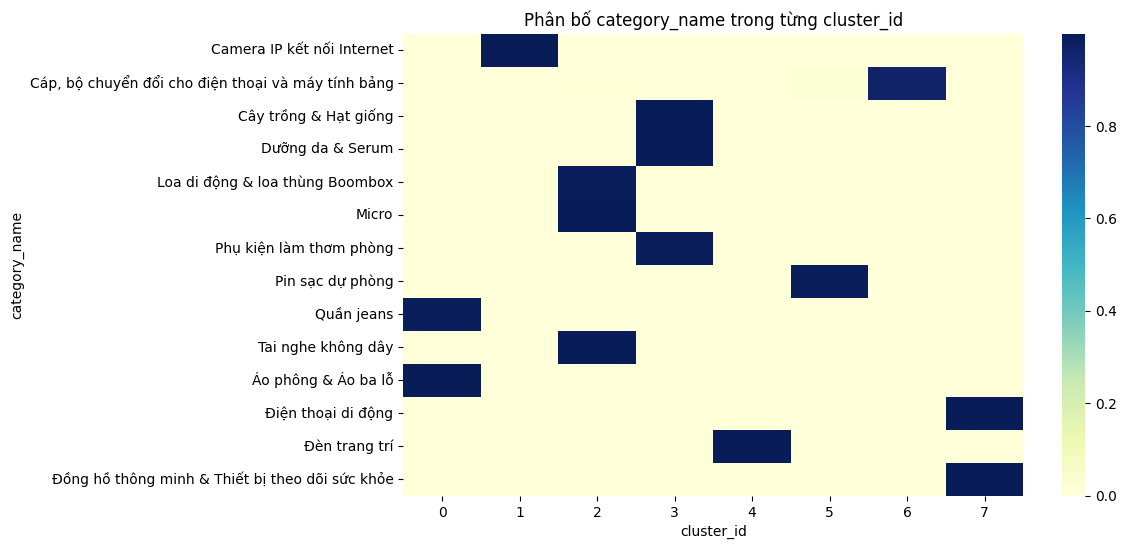

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

ct = pd.crosstab(meta["category_name"], meta["cluster_id"], normalize='index')
plt.figure(figsize=(10,6))
sns.heatmap(ct, cmap="YlGnBu")
plt.title("Phân bố category_name trong từng cluster_id")
plt.show()

In [18]:
EMB_PATH  = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/project_2A/social_networking/multilingual/outputs/embeddings.npy"
META_PATH = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/project_2A/social_networking/multilingual/outputs/metadata.parquet"


In [15]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

EMB_PATH  = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/multilingual/outputs/embeddings.npy"
META_PATH = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/multilingual/outputs/metadata.parquet"

Xn   = np.load(EMB_PATH)
meta = pd.read_parquet(META_PATH)

eps_list = np.round(np.arange(0.03, 0.13, 0.02), 3) 
min_samples_list = [5, 10, 20]

rows = []
for eps in eps_list:
    for ms in min_samples_list:
        db = DBSCAN(eps=eps, min_samples=ms, metric="cosine", n_jobs=-1)
        labels_tmp = db.fit_predict(Xn)
        mask = labels_tmp != -1
        n_valid = mask.sum()
        n_clusters = len(np.unique(labels_tmp[mask])) if n_valid > 0 else 0
        noise_ratio = 1.0 - (n_valid / len(labels_tmp))
        if n_clusters >= 2:
            sil = float(silhouette_score(Xn[mask], labels_tmp[mask], metric="cosine"))
            dbi = float(davies_bouldin_score(Xn[mask], labels_tmp[mask]))
            ch  = float(calinski_harabasz_score(Xn[mask], labels_tmp[mask]))
        else:
            sil = np.nan; dbi = np.nan; ch = np.nan
        rows.append({"eps": eps, "min_samples": ms, "n_clusters": n_clusters,
                     "noise_ratio": noise_ratio, "silhouette_cosine": sil, "DBI": dbi, "CH": ch})

df_gs = pd.DataFrame(rows)
df_gs_sorted = df_gs.copy()
df_gs_sorted["sil_rank"] = df_gs_sorted["silhouette_cosine"].fillna(-1e9)
df_gs_sorted = df_gs_sorted.sort_values(
    by=["sil_rank", "n_clusters", "noise_ratio"],
    ascending=[False, False, True]
).drop(columns=["sil_rank"])

best_eps = float(df_gs_sorted.iloc[0]["eps"])
best_ms  = int(df_gs_sorted.iloc[0]["min_samples"])

print("Top 10:")
print(df_gs_sorted.head(10).to_string(index=False))
print(f"\nBest params: eps={best_eps}, min_samples={best_ms}")

Top 10:
 eps  min_samples  n_clusters  noise_ratio  silhouette_cosine      DBI         CH
0.03           20          42     0.926373           0.670061 0.843933 275.124371
0.03            5         652     0.784412           0.640021 0.851707  72.921070
0.03           10         185     0.872448           0.634774 0.879775 129.697141
0.05           20          90     0.801495           0.396389 1.304502 153.590723
0.05           10         300     0.685815           0.322910 1.374303  73.578895
0.05            5         826     0.556244           0.302370 1.318169  40.229504
0.11           10           2     0.019485           0.124955 2.131916  10.341043
0.07           20          72     0.462859          -0.033888 1.876668  77.465968
0.11            5           8     0.014709          -0.035051 1.723076   5.590863
0.09           20          11     0.141606          -0.061136 2.027023 182.177835

Best params: eps=0.03, min_samples=20


In [16]:
# Cell 2 — Áp dụng DBSCAN tốt nhất, gán nhãn và lưu clusters_DBSCAN.parquet
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import os

OUT_PATH_DBSCAN = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/multilingual/clustering/clusters_DBSCAN.parquet"

db_best = DBSCAN(eps=best_eps, min_samples=best_ms, metric="cosine", n_jobs=-1)
labels_dbscan = db_best.fit_predict(Xn)
meta["cluster_id_dbscan"] = labels_dbscan

# Lưu file kết quả DBSCAN
os.makedirs(os.path.dirname(OUT_PATH_DBSCAN), exist_ok=True)
meta.to_parquet(OUT_PATH_DBSCAN, index=False)

mask = labels_dbscan != -1
n_clusters = len(np.unique(labels_dbscan[mask])) if mask.any() else 0
print("Số cụm (không tính noise):", n_clusters)
print(pd.Series(labels_dbscan[mask]).value_counts().sort_index())

Số cụm (không tính noise): 42
0      22
1      62
2      78
3      20
4      20
5      71
6      67
7      56
8      35
9      21
10    340
11     32
12     20
13    108
14     32
15     63
16     20
17     52
18    187
19     63
20     20
21     26
22     31
23     52
24     34
25     27
26     20
27     22
28     22
29     77
30     50
31     44
32     38
33     36
34     67
35     25
36     22
37     34
38     35
39    487
40     71
41     89
Name: count, dtype: int64


In [17]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score, normalized_mutual_info_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import contingency_matrix

EVAL_PATH = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/multilingual/clustering/evaluation_multilingual.csv"

mask = meta["cluster_id_dbscan"].values != -1
if mask.sum() >= 2 and len(np.unique(meta.loc[mask, "cluster_id_dbscan"])) >= 2:
    sil = float(silhouette_score(Xn[mask], meta.loc[mask, "cluster_id_dbscan"], metric="cosine"))
    dbi = float(davies_bouldin_score(Xn[mask], meta.loc[mask, "cluster_id_dbscan"]))
    ch  = float(calinski_harabasz_score(Xn[mask], meta.loc[mask, "cluster_id_dbscan"]))
else:
    sil = np.nan; dbi = np.nan; ch = np.nan
print(f"[DBSCAN | Unsupervised] Silhouette={sil} | DBI={dbi} | CH={ch}")

nmi = ari = pur = None
if "category_name" in meta.columns:
    mask2 = mask & meta["category_name"].notna()
    if mask2.any() and len(np.unique(meta.loc[mask2, "cluster_id_dbscan"])) >= 2:
        y_true = LabelEncoder().fit_transform(meta.loc[mask2, "category_name"].astype(str))
        y_pred = meta.loc[mask2, "cluster_id_dbscan"].values

        def purity_score(y_true, y_pred):
            cm = contingency_matrix(y_true, y_pred)
            return cm.max(axis=0).sum() / cm.sum()

        nmi = float(normalized_mutual_info_score(y_true, y_pred, average_method="arithmetic"))
        ari = float(adjusted_rand_score(y_true, y_pred))
        pur = float(purity_score(y_true, y_pred))
        print(f"[DBSCAN | Supervised] NMI={nmi} | ARI={ari} | Purity={pur}")

rec_unsup = pd.DataFrame([{
    "model": "DBSCAN", "metric": "cosine",
    "eps": best_eps, "min_samples": best_ms,
    "type": "unsupervised",
    "silhouette_cosine": sil, "DBI": dbi, "CH": ch,
    "NMI": None, "ARI": None, "Purity": None
}])

rec_sup = pd.DataFrame([{
    "model": "DBSCAN", "metric": "cosine",
    "eps": best_eps, "min_samples": best_ms,
    "type": "supervised",
    "silhouette_cosine": None, "DBI": None, "CH": None,
    "NMI": nmi, "ARI": ari, "Purity": pur
}])

df_out = pd.read_csv(EVAL_PATH) if os.path.exists(EVAL_PATH) else pd.DataFrame()
df_out = pd.concat([df_out, rec_unsup, rec_sup], ignore_index=True)
df_out.to_csv(EVAL_PATH, index=False)

[DBSCAN | Unsupervised] Silhouette=0.670060932636261 | DBI=0.843933157519553 | CH=275.1243713077141
[DBSCAN | Supervised] NMI=0.7577404370536293 | ARI=0.5279607038746398 | Purity=1.0


/var/folders/sc/09_755c96_5cwxwdx8y9kscm0000gn/T/ipykernel_76354/154102264.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat([df_out, rec_unsup, rec_sup], ignore_index=True)


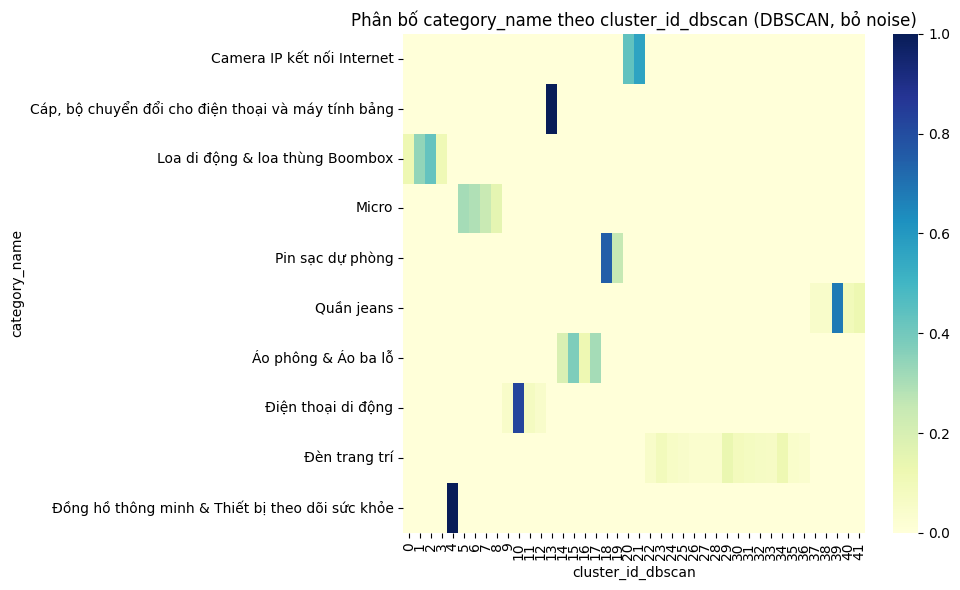

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_vis = meta.copy()
df_vis = df_vis[df_vis["cluster_id_dbscan"] != -1]  # bỏ noise để nhìn rõ
if "category_name" in df_vis.columns:
    ct = pd.crosstab(df_vis["category_name"], df_vis["cluster_id_dbscan"], normalize="index")
    plt.figure(figsize=(10, 6))
    sns.heatmap(ct, cmap="YlGnBu")
    plt.title("Phân bố category_name theo cluster_id_dbscan (DBSCAN, bỏ noise)")
    plt.tight_layout()
    plt.show()
else:
    print("Không có cột category_name để trực quan.")

In [19]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Load dữ liệu
Xn = np.load(EMB_PATH)
meta = pd.read_parquet(META_PATH)

# Danh sách số cụm để thử
n_components_list = [6, 10, 14, 16, 20, 30]
rows = []

for k in n_components_list:
    try:
        gmm = GaussianMixture(
            n_components=k,
            covariance_type="diag", 
            reg_covar=1e-4,
            random_state=42
        ).fit(Xn)
        labels_tmp = gmm.predict(Xn)

        sil = float(silhouette_score(Xn, labels_tmp, metric="cosine"))
        rows.append({"n_components": k, "silhouette_cosine": sil})
    except Exception:
        rows.append({"n_components": k, "silhouette_cosine": np.nan})

df_gmm = pd.DataFrame(rows).sort_values(
    "silhouette_cosine", ascending=False
).reset_index(drop=True)

best_n = int(df_gmm.iloc[0]["n_components"])

print(df_gmm.to_string(index=False))
print(f"\nBest params (by silhouette): n_components={best_n}")

 n_components  silhouette_cosine
           10           0.183493
           14           0.156887
            6           0.151524
           16           0.141044
           20           0.122766
           30           0.115060

Best params (by silhouette): n_components=10


In [20]:
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd
import os

OUT_PATH_GMM = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/multilingual/clustering/clusters_GMM.parquet"

gmm = GaussianMixture(
    n_components=best_n,
    covariance_type="diag",  
    reg_covar=1e-4,
    random_state=42
)
labels_gmm = gmm.fit_predict(Xn)
meta["cluster_id_gmm"] = labels_gmm

# Lưu file kết quả
os.makedirs(os.path.dirname(OUT_PATH_GMM), exist_ok=True)
meta.to_parquet(OUT_PATH_GMM, index=False)

# Thống kê nhanh
uniq, cnt = np.unique(labels_gmm, return_counts=True)
print("best_K:", best_n, "| n_clusters:", len(uniq))
for k, c in zip(uniq, cnt):
    print(f"cluster {k}: {c}")

# Nếu có nhãn thật thì in thêm
if "category_name" in meta.columns:
    n_true = meta["category_name"].nunique()
    print("\nSố cụm thật (category_name):", n_true)

best_K: 10 | n_clusters: 10
cluster 0: 4924
cluster 1: 3872
cluster 2: 3666
cluster 3: 3922
cluster 4: 2873
cluster 5: 3244
cluster 6: 3056
cluster 7: 3406
cluster 8: 2706
cluster 9: 4975

Số cụm thật (category_name): 14


In [21]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score, normalized_mutual_info_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import contingency_matrix

EVAL_PATH = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/multilingual/clustering/evaluation_multilingual.csv"

# --- Guard nếu số cụm < 2 ---
n_clusters = np.unique(labels_gmm).size
if n_clusters >= 2:
    sil = float(silhouette_score(Xn, labels_gmm, metric="cosine"))
    dbi = float(davies_bouldin_score(Xn, labels_gmm))
    ch  = float(calinski_harabasz_score(Xn, labels_gmm))
else:
    sil = dbi = ch = np.nan
print(f"[GMM | Unsupervised] Silhouette={sil:.4f} | DBI={dbi:.4f} | CH={ch:.2f}")

# --- Supervised (nếu có nhãn) ---
nmi = ari = pur = None
if "category_name" in meta.columns:
    mask = meta["category_name"].notna()
    if mask.any() and meta.loc[mask, "cluster_id_gmm"].nunique() >= 2:
        y_true = LabelEncoder().fit_transform(meta.loc[mask, "category_name"].astype(str))
        y_pred = meta.loc[mask, "cluster_id_gmm"].values

        def purity_score(y_true, y_pred):
            cm = contingency_matrix(y_true, y_pred)
            return cm.max(axis=0).sum() / cm.sum()

        nmi = float(normalized_mutual_info_score(y_true, y_pred, average_method="arithmetic"))
        ari = float(adjusted_rand_score(y_true, y_pred))
        pur = float(purity_score(y_true, y_pred))
        print(f"[GMM | Supervised] NMI={nmi:.4f} | ARI={ari:.4f} | Purity={pur:.4f}")

# --- Append CSV (ghi rõ metric dùng cho silhouette) ---
rec_unsup = pd.DataFrame([{
    "model": "GMM",
    "n_components": best_n,
    "type": "unsupervised",
    "silhouette_metric": "cosine",
    "silhouette_cosine": sil,
    "DBI": dbi,
    "CH": ch,
    "NMI": None,
    "ARI": None,
    "Purity": None
}])

rec_sup = pd.DataFrame([{
    "model": "GMM",
    "n_components": best_n,
    "type": "supervised",
    "silhouette_metric": None,
    "silhouette_cosine": None,
    "DBI": None,
    "CH": None,
    "NMI": nmi,
    "ARI": ari,
    "Purity": pur
}])

df_out = pd.read_csv(EVAL_PATH) if os.path.exists(EVAL_PATH) else pd.DataFrame()
df_out = pd.concat([df_out, rec_unsup, rec_sup], ignore_index=True)
df_out.to_csv(EVAL_PATH, index=False)

[GMM | Unsupervised] Silhouette=0.1835 | DBI=3.0048 | CH=1360.81
[GMM | Supervised] NMI=0.9128 | ARI=0.8199 | Purity=0.7922


/var/folders/sc/09_755c96_5cwxwdx8y9kscm0000gn/T/ipykernel_98483/50269968.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat([df_out, rec_unsup, rec_sup], ignore_index=True)


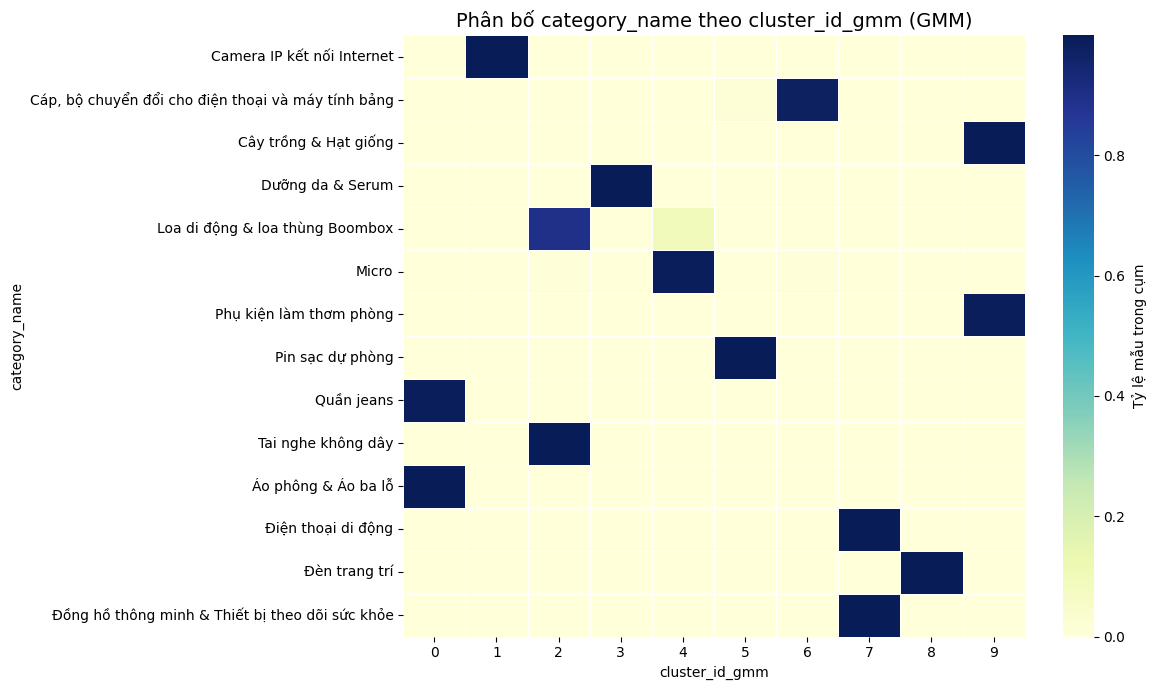

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Giả định meta có 2 cột: category_name (nhãn thật) và cluster_id_gmm (nhãn phân cụm) ---
df_viz = (
    meta.groupby(["category_name", "cluster_id_gmm"])
        .size()
        .reset_index(name="count")
)

# Chuẩn hóa tần suất theo từng category (để so sánh dễ)
df_viz["ratio"] = (
    df_viz.groupby("category_name")["count"].transform(lambda x: x / x.sum())
)

# Pivot thành ma trận để vẽ heatmap
heatmap_data = df_viz.pivot(index="category_name", columns="cluster_id_gmm", values="ratio").fillna(0)

# --- Vẽ heatmap ---
plt.figure(figsize=(12, 7))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    linewidths=0.5,
    annot=False,
    cbar_kws={'label': 'Tỷ lệ mẫu trong cụm'}
)
plt.title("Phân bố category_name theo cluster_id_gmm (GMM)", fontsize=14)
plt.xlabel("cluster_id_gmm")
plt.ylabel("category_name")
plt.tight_layout()
plt.show()

## TF-IDF

### Xử lý

In [9]:
import pandas as pd

# 🔹 Đường dẫn đến file mới
CSV_PATH = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/project_2A/social_networking/traditional/description_clean.csv"

# 🔹 Đọc dữ liệu
df = pd.read_csv(CSV_PATH)
print("Cột:", df.columns.tolist())
print("Tổng dòng gốc:", len(df))

# 🔹 Xử lý dữ liệu trống
df["category_name"] = df["category_name"].fillna("unknown").astype(str)
df["description"]   = df["description"].fillna("").astype(str)

# 🔹 Loại bỏ mô tả trống hoặc chỉ chứa khoảng trắng
df_keep = df[df["description"].str.strip().ne("")].reset_index(drop=True)
print("Số dòng sau khi loại trắng:", len(df_keep))

# 🔹 Đếm số từ trong mỗi mô tả
df_keep["word_count"] = df_keep["description"].str.split().apply(len)

# 🔹 Thống kê độ dài mô tả
print("\nThống kê độ dài mô tả:")
print(df_keep["word_count"].describe())

# 🔹 Tổng số từ trong toàn bộ file
total_words = df_keep["word_count"].sum()
print(f"\nTổng số từ trong toàn bộ mô tả: {total_words:,}")

Cột: ['category_name', 'description']
Tổng dòng gốc: 36644
Số dòng sau khi loại trắng: 36644

Thống kê độ dài mô tả:
count    36644.000000
mean       311.040498
std        209.089524
min          6.000000
25%        166.000000
50%        271.000000
75%        402.000000
max       5135.000000
Name: word_count, dtype: float64

Tổng số từ trong toàn bộ mô tả: 11,397,768


In [6]:
# Cell 1 — Load CSV + kiểm tra dữ liệu, làm sạch cơ bản
import pandas as pd

CSV_PATH = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/traditional/description_clean.csv"

df = pd.read_csv(CSV_PATH)

print("Cột:", df.columns.tolist())
print("Tổng dòng gốc:", len(df))

required_cols = {"category_name", "description"}
missing = required_cols - set(df.columns)
assert not missing, f"Thiếu cột: {missing}"

df["category_name"] = df["category_name"].fillna("unknown").astype(str)
df["description"]   = df["description"].fillna("").astype(str)

n_na      = df["description"].isna().sum()
n_empty   = (df["description"] == "").sum()
n_ws_only = df["description"].str.strip().eq("").sum()
print(f"NaN: {n_na} | empty '': {n_empty} | whitespace-only: {n_ws_only}")

n_dups_desc = df.duplicated(subset=["description"]).sum()
print(f"Số dòng trùng mô tả (không tính dòng đầu tiên): {n_dups_desc}")

df_keep = df[df["description"].str.strip().ne("")].reset_index(drop=True)
print("Số dòng sau khi loại trắng:", len(df_keep))

print("\nVí dụ mô tả:")
print(df_keep[["category_name", "description"]].head(3))

Cột: ['category_name', 'description']
Tổng dòng gốc: 36644
NaN: 0 | empty '': 0 | whitespace-only: 0
Số dòng trùng mô tả (không tính dòng đầu tiên): 3433
Số dòng sau khi loại trắng: 36644

Ví dụ mô tả:
                     category_name  \
0  Loa di động & loa thùng Boombox   
1  Loa di động & loa thùng Boombox   
2  Loa di động & loa thùng Boombox   

                                         description  
0  product details product details loa bluetooth ...  
1  đặc điểm nổi bật đặc điểm nổi bật công nghệ jb...  
2  thông kỹ thuật loa bluetooth boombox 3 loa di ...  


In [11]:
import numpy as np
import pandas as pd
import os
from scipy import sparse
from joblib import dump
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

OUT_DIR = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/traditional/outputs_traditional"
os.makedirs(OUT_DIR, exist_ok=True)

texts = df_keep["description"].tolist()

tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    dtype=np.float32,
    norm="l2"
)
X_tfidf = tfidf.fit_transform(texts)
print("TF-IDF shape:", X_tfidf.shape)
density = X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])
print(f"Sparse density: {density:.6f} ({density*100:.4f}%)")

SPARSE_PATH = f"{OUT_DIR}/tfidf_word.npz"
sparse.save_npz(SPARSE_PATH, X_tfidf)
print("Đã lưu TF-IDF sparse:", SPARSE_PATH)

SVD_DIM = 256
svd = TruncatedSVD(n_components=SVD_DIM, random_state=42, n_iter=7) 
X_svd = svd.fit_transform(X_tfidf)
Xn = normalize(X_svd)
print("SVD embedding shape:", Xn.shape)

SVD_PATH = f"{OUT_DIR}/traditional_embeddings.npy"
np.save(SVD_PATH, Xn.astype(np.float32))
print("Đã lưu embedding:", SVD_PATH)

META_PATH = f"{OUT_DIR}/metadata_traditional.parquet"
df_keep.to_parquet(META_PATH, index=False)
print("Đã lưu metadata:", META_PATH)

dump(tfidf, f"{OUT_DIR}/tfidf_word12.joblib")
dump(svd,   f"{OUT_DIR}/svd256.joblib")

TF-IDF shape: (36644, 525051)
Sparse density: 0.000667 (0.0667%)
Đã lưu TF-IDF sparse: /Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/traditional/outputs_traditional/tfidf_word.npz
SVD embedding shape: (36644, 256)
Đã lưu embedding: /Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/traditional/outputs_traditional/traditional_embeddings.npy
Đã lưu metadata: /Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/traditional/outputs_traditional/metadata_traditional.parquet


['/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/traditional/outputs_traditional/svd256.joblib']

In [ ]:
import numpy as np, pandas as pd, os

OUT_DIR   = "/Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/traditional/outputs_traditional"
EMB_PATH  = f"{OUT_DIR}/traditional_embeddings.npy"
META_PATH = f"{OUT_DIR}/metadata_traditional.parquet"
EVAL_PATH = f"{OUT_DIR}/evaluation_traditional.csv"


Xn   = np.load(EMB_PATH)              
meta = pd.read_parquet(META_PATH)     
assert Xn.shape[0] == len(meta)
print("Embeddings:", Xn.shape, "| Meta:", meta.shape)

Embeddings: (36644, 256) | Meta: (36644, 2)


### Kmean

In [19]:
import numpy as np, pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Ks = [4, 8, 12, 16, 20, 24, 28, 30, 40, 50]

rows = []
for K in Ks:
    labels = KMeans(n_clusters=K, n_init="auto", random_state=42).fit_predict(Xn)
    sil = float(silhouette_score(Xn, labels, metric="cosine"))
    rows.append((K, sil))

df_k = pd.DataFrame(rows, columns=["K","silhouette_cosine"]).sort_values("silhouette_cosine", ascending=False)
best_K = int(df_k.iloc[0]["K"])
print(df_k.to_string(index=False))
print("best_K:", best_K)

 K  silhouette_cosine
16           0.297332
12           0.258822
20           0.242280
24           0.237848
28           0.222344
30           0.218352
50           0.218312
40           0.208597
 8           0.196702
 4           0.132935
best_K: 16


In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
import pandas as pd, os, numpy as np

km = KMeans(n_clusters=best_K, n_init="auto", random_state=42).fit(Xn)
labels_km = km.labels_

# Thống kê quy mô cụm
uniq, cnt = np.unique(labels_km, return_counts=True)
print("best_K:", best_K, "| n_clusters:", len(uniq))
for k, c in zip(uniq, cnt):
    print(f"cluster {k}: {c}")

# Unsupervised
sil = float(silhouette_score(Xn, labels_km, metric="cosine"))
dbi = float(davies_bouldin_score(Xn, labels_km))
ch  = float(calinski_harabasz_score(Xn, labels_km))
print(f"[KMeans | Unsupervised] Silhouette={sil:.4f} | DBI={dbi:.4f} | CH={ch:.2f}")

# Supervised (nếu có category_name trong metadata)
y_true = LabelEncoder().fit_transform(meta["category_name"].astype(str).values)
def purity_score(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return cm.max(axis=0).sum() / cm.sum()
nmi = float(normalized_mutual_info_score(y_true, labels_km, average_method="arithmetic"))
ari = float(adjusted_rand_score(y_true, labels_km))
pur = float(purity_score(y_true, labels_km))
print(f"[KMeans | Supervised] NMI={nmi:.4f} | ARI={ari:.4f} | Purity={pur:.4f}")

# Append CSV
rec_unsup = pd.DataFrame([{"model":"KMeans","metric":"cosine","K":best_K,"type":"unsupervised",
                           "silhouette_cosine":sil,"DBI":dbi,"CH":ch,"NMI":None,"ARI":None,"Purity":None}])
rec_sup   = pd.DataFrame([{"model":"KMeans","metric":"cosine","K":best_K,"type":"supervised",
                           "silhouette_cosine":None,"DBI":None,"CH":None,"NMI":nmi,"ARI":ari,"Purity":pur}])

df_out = pd.read_csv(EVAL_PATH) if os.path.exists(EVAL_PATH) else pd.DataFrame()
df_out = pd.concat([df_out, rec_unsup, rec_sup], ignore_index=True)
df_out.to_csv(EVAL_PATH, index=False)
print("Appended:", EVAL_PATH)

best_K: 16 | n_clusters: 16
cluster 0: 2309
cluster 1: 3805
cluster 2: 1324
cluster 3: 3837
cluster 4: 3269
cluster 5: 2934
cluster 6: 2144
cluster 7: 880
cluster 8: 1717
cluster 9: 1968
cluster 10: 1777
cluster 11: 3017
cluster 12: 1965
cluster 13: 802
cluster 14: 1922
cluster 15: 2974
[KMeans | Unsupervised] Silhouette=0.2973 | DBI=2.5105 | CH=1328.53
[KMeans | Supervised] NMI=0.9016 | ARI=0.8642 | Purity=0.9238
Appended: /Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/traditional/outputs_traditional/evaluation_traditional.csv


/var/folders/sc/09_755c96_5cwxwdx8y9kscm0000gn/T/ipykernel_53562/1911284028.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat([df_out, rec_unsup, rec_sup], ignore_index=True)


In [21]:
# DBSCAN — Grid search chỉ theo Silhouette (cosine), chọn best và fit lại
import numpy as np, pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Bạn có thể chỉnh phạm vi/dải eps & min_samples
EPS_LIST = [0.003, 0.005, 0.007, 0.009, 0.011]
MS_LIST  = [5, 8, 10, 12, 15]

rows = []
for eps in EPS_LIST:
    for ms in MS_LIST:
        labels = DBSCAN(eps=eps, min_samples=ms, metric="cosine", n_jobs=-1).fit_predict(Xn)
        mask = labels != -1
        # Silhouette cần >=2 cụm hợp lệ
        if mask.sum() >= 2 and len(np.unique(labels[mask])) >= 2:
            sil = float(silhouette_score(Xn[mask], labels[mask], metric="cosine"))
        else:
            sil = np.nan
        rows.append((eps, ms, sil, int((~mask).sum()) / len(labels)))

df = pd.DataFrame(rows, columns=["eps","min_samples","silhouette_cosine","noise_frac"])
df_sorted = df.sort_values("silhouette_cosine", ascending=False, na_position="last")
print(df_sorted.head(15).to_string(index=False))

# Chọn cấu hình tốt nhất theo silhouette
best = df_sorted.dropna(subset=["silhouette_cosine"]).iloc[0]
best_eps = float(best.eps)
best_ms  = int(best.min_samples)
print(f"\nChọn: eps={best_eps}, min_samples={best_ms} | sil={best.silhouette_cosine:.4f}")

labels_best = DBSCAN(eps=best_eps, min_samples=best_ms, metric="cosine", n_jobs=-1).fit_predict(Xn)
noise = int((labels_best == -1).sum())
uniq, cnt = np.unique(labels_best[labels_best != -1], return_counts=True)
print(f"clusters={len(uniq)} | noise={noise}/{len(labels_best)} ({noise/len(labels_best):.2%})")
for k, c in zip(uniq, cnt):
    print(f"cluster {k}: {c}")

  eps  min_samples  silhouette_cosine  noise_frac
0.003           15           0.986322    0.950579
0.003           12           0.979045    0.941273
0.005           15           0.966767    0.938844
0.011           15           0.963918    0.913601
0.003           10           0.961958    0.927601
0.005           10           0.961367    0.910517
0.009           12           0.961332    0.904432
0.009           15           0.961201    0.920014
0.007           15           0.960631    0.928037
0.005           12           0.960126    0.925254
0.009           10           0.956028    0.886257
0.011           12           0.954892    0.897446
0.003            8           0.949820    0.914202
0.005            8           0.948008    0.894662
0.007           12           0.947030    0.914529

Chọn: eps=0.003, min_samples=15 | sil=0.9863
clusters=63 | noise=34833/36644 (95.06%)
cluster 0: 62
cluster 1: 24
cluster 2: 39
cluster 3: 79
cluster 4: 15
cluster 5: 15
cluster 6: 15
cluster 7: 15
c

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
import numpy as np, pandas as pd, os

db = DBSCAN(eps=best_eps, min_samples=best_ms, metric="cosine", n_jobs=-1).fit(Xn)
labels_db = db.labels_

# Thống kê
noise = int((labels_db == -1).sum())
uniq, cnt = np.unique(labels_db[labels_db != -1], return_counts=True)
print(f"eps={best_eps}, min_samples={best_ms}")
print(f"clusters={len(uniq)} | noise={noise}/{len(labels_db)} ({noise/len(labels_db):.2%})")
for k, c in zip(uniq, cnt):
    print(f"cluster {k}: {c}")

# Unsupervised
mask = (labels_db != -1)
if mask.sum() >= 2 and len(np.unique(labels_db[mask])) >= 2:
    sil = float(silhouette_score(Xn[mask], labels_db[mask], metric="cosine"))
    dbi = float(davies_bouldin_score(Xn[mask], labels_db[mask]))
    ch  = float(calinski_harabasz_score(Xn[mask], labels_db[mask]))
else:
    sil = dbi = ch = float("nan")
print(f"[DBSCAN | Unsupervised] Silhouette={sil:.4f} | DBI={dbi} | CH={ch}")

# Supervised
y_true = LabelEncoder().fit_transform(meta["category_name"].astype(str).values)
def purity_score(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return cm.max(axis=0).sum() / cm.sum()
nmi = float(normalized_mutual_info_score(y_true, labels_db, average_method="arithmetic"))
ari = float(adjusted_rand_score(y_true, labels_db))
pur = float(purity_score(y_true, labels_db))
print(f"[DBSCAN | Supervised] NMI={nmi:.4f} | ARI={ari:.4f} | Purity={pur:.4f}")

# Append CSV
rec_unsup = pd.DataFrame([{"model":"DBSCAN","metric":"cosine","K":"","type":"unsupervised",
                           "silhouette_cosine":sil,"DBI":dbi,"CH":ch,"NMI":None,"ARI":None,"Purity":None}])
rec_sup   = pd.DataFrame([{"model":"DBSCAN","metric":"cosine","K":"","type":"supervised",
                           "silhouette_cosine":None,"DBI":None,"CH":None,"NMI":nmi,"ARI":ari,"Purity":pur}])

df_out = pd.read_csv(EVAL_PATH) if os.path.exists(EVAL_PATH) else pd.DataFrame()
df_out = pd.concat([df_out, rec_unsup, rec_sup], ignore_index=True)
df_out.to_csv(EVAL_PATH, index=False)
print("Appended:", EVAL_PATH)

eps=0.003, min_samples=15
clusters=63 | noise=34833/36644 (95.06%)
cluster 0: 62
cluster 1: 24
cluster 2: 39
cluster 3: 79
cluster 4: 15
cluster 5: 15
cluster 6: 15
cluster 7: 15
cluster 8: 18
cluster 9: 67
cluster 10: 17
cluster 11: 30
cluster 12: 17
cluster 13: 23
cluster 14: 20
cluster 15: 32
cluster 16: 22
cluster 17: 18
cluster 18: 21
cluster 19: 15
cluster 20: 19
cluster 21: 15
cluster 22: 88
cluster 23: 15
cluster 24: 20
cluster 25: 17
cluster 26: 47
cluster 27: 20
cluster 28: 30
cluster 29: 16
cluster 30: 28
cluster 31: 31
cluster 32: 52
cluster 33: 27
cluster 34: 16
cluster 35: 18
cluster 36: 19
cluster 37: 21
cluster 38: 22
cluster 39: 85
cluster 40: 32
cluster 41: 46
cluster 42: 19
cluster 43: 42
cluster 44: 50
cluster 45: 17
cluster 46: 25
cluster 47: 16
cluster 48: 16
cluster 49: 16
cluster 50: 16
cluster 51: 26
cluster 52: 18
cluster 53: 34
cluster 54: 30
cluster 55: 70
cluster 56: 36
cluster 57: 38
cluster 58: 15
cluster 59: 27
cluster 60: 16
cluster 61: 20
cluster 62: 1

/var/folders/sc/09_755c96_5cwxwdx8y9kscm0000gn/T/ipykernel_53562/1266637638.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat([df_out, rec_unsup, rec_sup], ignore_index=True)


### GMM

In [23]:
import numpy as np, pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
import os

# Tìm K
Ks = [4, 8, 12, 14, 16, 20, 24, 28, 30]
rows = []
for K in Ks:
    gmm = GaussianMixture(n_components=K, covariance_type="diag", reg_covar=1e-4, random_state=42)
    labels = gmm.fit_predict(Xn)
    sil = float(silhouette_score(Xn, labels, metric="cosine"))
    rows.append((K, sil))
df_k_gmm = pd.DataFrame(rows, columns=["K","silhouette_cosine"]).sort_values("silhouette_cosine", ascending=False)
best_K_gmm = int(df_k_gmm.iloc[0]["K"])
print(df_k_gmm.to_string(index=False))
print("best_K_gmm:", best_K_gmm)

# Fit + thống kê
gmm = GaussianMixture(n_components=best_K_gmm, covariance_type="diag", reg_covar=1e-4, random_state=42)
labels_gmm = gmm.fit_predict(Xn)
uniq, cnt = np.unique(labels_gmm, return_counts=True)
print("best_K_gmm:", best_K_gmm, "| n_clusters:", len(uniq))
for k, c in zip(uniq, cnt):
    print(f"cluster {k}: {c}")

# Unsupervised
sil = float(silhouette_score(Xn, labels_gmm, metric="cosine"))
dbi = float(davies_bouldin_score(Xn, labels_gmm))
ch  = float(calinski_harabasz_score(Xn, labels_gmm))
print(f"[GMM | Unsupervised] Silhouette={sil:.4f} | DBI={dbi:.4f} | CH={ch:.2f}")

# Supervised
y_true = LabelEncoder().fit_transform(meta["category_name"].astype(str).values)
def purity_score(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return cm.max(axis=0).sum() / cm.sum()
nmi = float(normalized_mutual_info_score(y_true, labels_gmm, average_method="arithmetic"))
ari = float(adjusted_rand_score(y_true, labels_gmm))
pur = float(purity_score(y_true, labels_gmm))
print(f"[GMM | Supervised] NMI={nmi:.4f} | ARI={ari:.4f} | Purity={pur:.4f}")

# Append CSV
rec_unsup = pd.DataFrame([{"model":"GMM","metric":"cosine","K":best_K_gmm,"type":"unsupervised",
                           "silhouette_cosine":sil,"DBI":dbi,"CH":ch,"NMI":None,"ARI":None,"Purity":None}])
rec_sup   = pd.DataFrame([{"model":"GMM","metric":"cosine","K":best_K_gmm,"type":"supervised",
                           "silhouette_cosine":None,"DBI":None,"CH":None,"NMI":nmi,"ARI":ari,"Purity":pur}])

df_out = pd.read_csv(EVAL_PATH) if os.path.exists(EVAL_PATH) else pd.DataFrame()
df_out = pd.concat([df_out, rec_unsup, rec_sup], ignore_index=True)
df_out.to_csv(EVAL_PATH, index=False)
print("Appended:", EVAL_PATH)

 K  silhouette_cosine
16           0.276258
14           0.257730
12           0.227128
24           0.214674
20           0.211783
28           0.203005
30           0.202748
 8           0.189525
 4           0.124304
best_K_gmm: 16
best_K_gmm: 16 | n_clusters: 16
cluster 0: 1953
cluster 1: 3665
cluster 2: 2579
cluster 3: 3686
cluster 4: 4303
cluster 5: 2574
cluster 6: 1994
cluster 7: 866
cluster 8: 1214
cluster 9: 1908
cluster 10: 1916
cluster 11: 2826
cluster 12: 1864
cluster 13: 757
cluster 14: 1623
cluster 15: 2916
[GMM | Unsupervised] Silhouette=0.2763 | DBI=2.7836 | CH=1275.06
[GMM | Supervised] NMI=0.8353 | ARI=0.7479 | Purity=0.8617
Appended: /Users/huy/Documents/Hutech/HK1A 2025-2026/social-networking/social_networking/traditional/outputs_traditional/evaluation_traditional.csv


/var/folders/sc/09_755c96_5cwxwdx8y9kscm0000gn/T/ipykernel_53562/4111760055.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat([df_out, rec_unsup, rec_sup], ignore_index=True)


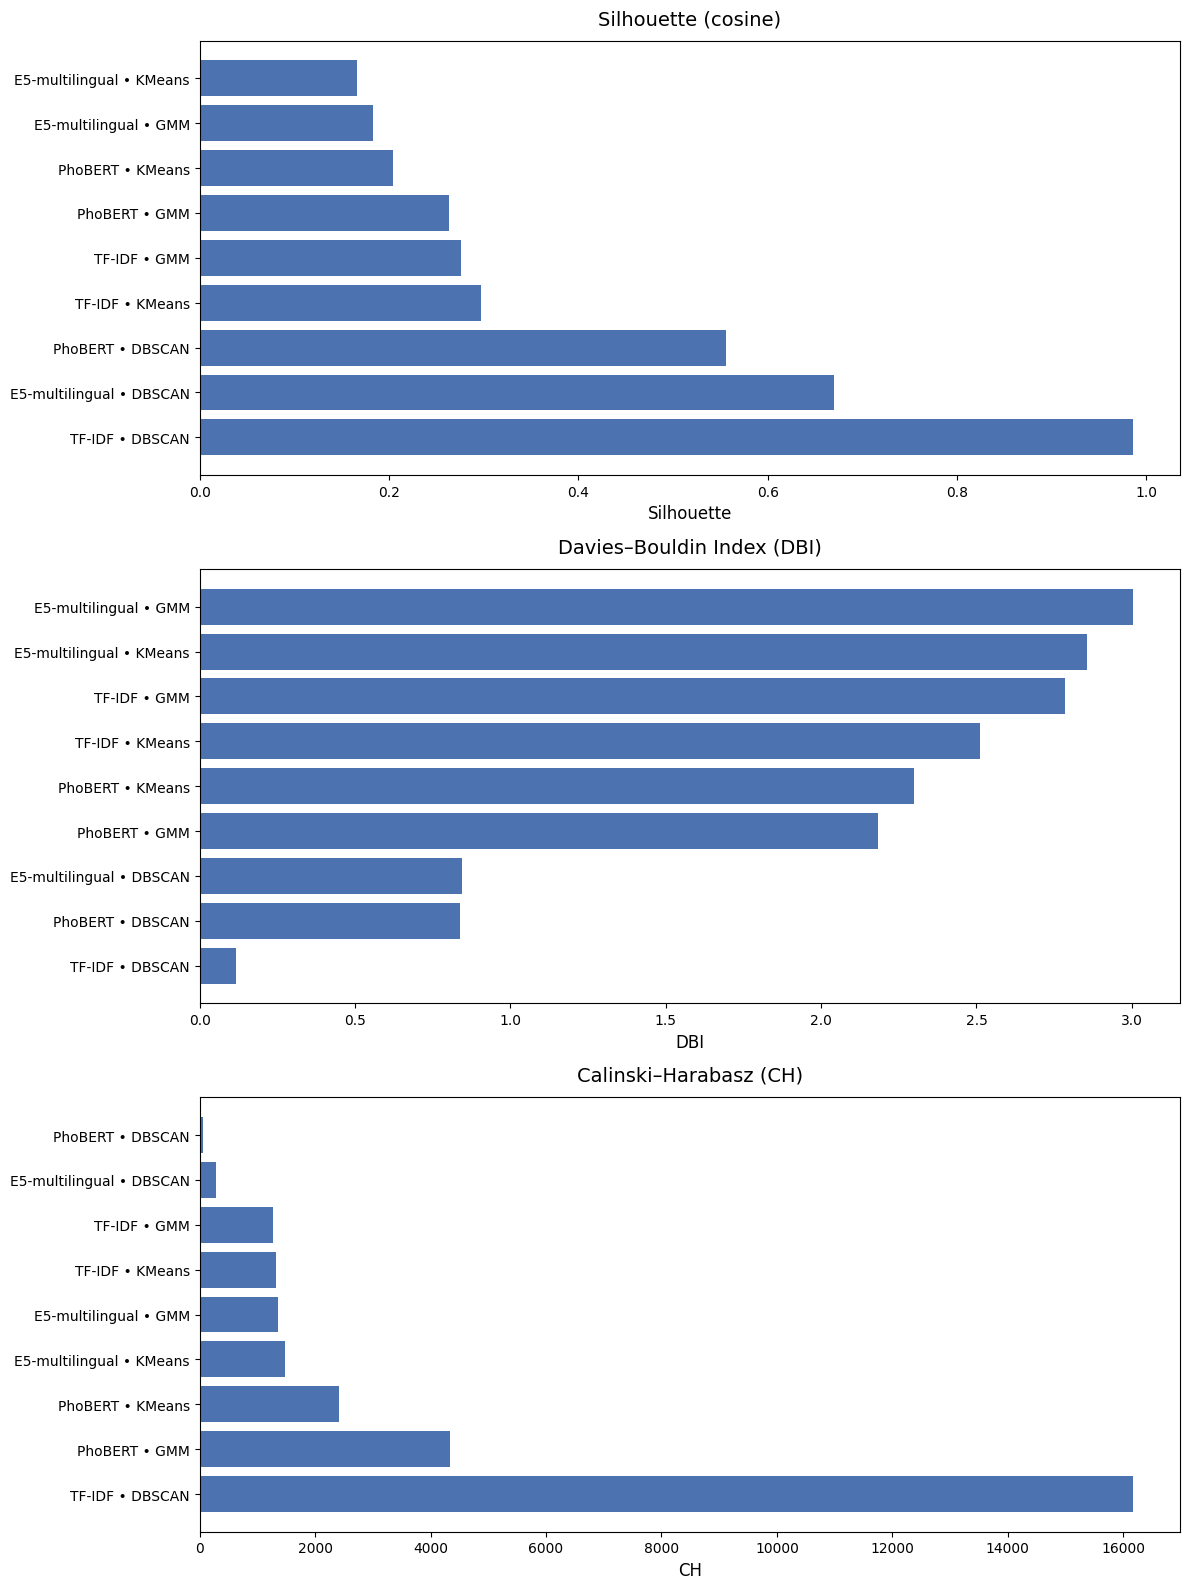

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# ====== DỮ LIỆU KHÔNG GIÁM SÁT ======
unsup_rows = [
    ("TF-IDF",        "KMeans",  0.2973, 2.5105, 1328.53),
    ("TF-IDF",        "DBSCAN",  0.9863, 0.1161, 16175.46),
    ("TF-IDF",        "GMM",     0.2763, 2.7836, 1275.06),
    ("PhoBERT",       "KMeans",  0.2047, 2.2994, 2418.46),
    ("PhoBERT",       "DBSCAN",  0.5558, 0.8371, 48.36),
    ("PhoBERT",       "GMM",     0.2637, 2.1819, 4331.95),
    ("E5-multilingual","KMeans", 0.1659, 2.8550, 1471.18),
    ("E5-multilingual","DBSCAN", 0.6701, 0.8439, 275.12),
    ("E5-multilingual","GMM",    0.1835, 3.0048, 1360.81),
]

df_unsup = pd.DataFrame(unsup_rows, columns=["Embedding","Algorithm","Silhouette","DBI","CH"])
df_unsup["Label"] = df_unsup["Embedding"] + " • " + df_unsup["Algorithm"]

def plot_barh_sorted(ax, df, value_col, title, ascending=False, xlabel=None):
    d = df.sort_values(value_col, ascending=ascending)
    ax.barh(d["Label"], d[value_col], color="#4C72B0")
    ax.set_title(title, fontsize=14, pad=12)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=12)
    ax.tick_params(axis='y', labelsize=10)

# ====== VẼ 1 HÌNH VỚI 3 SUBPLOTS ======
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 16))
plt.subplots_adjust(hspace=0.5)

plot_barh_sorted(
    axes[0], df_unsup, "Silhouette",
    "Silhouette (cosine)",
    ascending=False, xlabel="Silhouette"
)
plot_barh_sorted(
    axes[1], df_unsup, "DBI",
    "Davies–Bouldin Index (DBI)",
    ascending=True, xlabel="DBI"
)
plot_barh_sorted(
    axes[2], df_unsup, "CH",
    "Calinski–Harabasz (CH)",
    ascending=False, xlabel="CH"
)

plt.tight_layout()
plt.show()

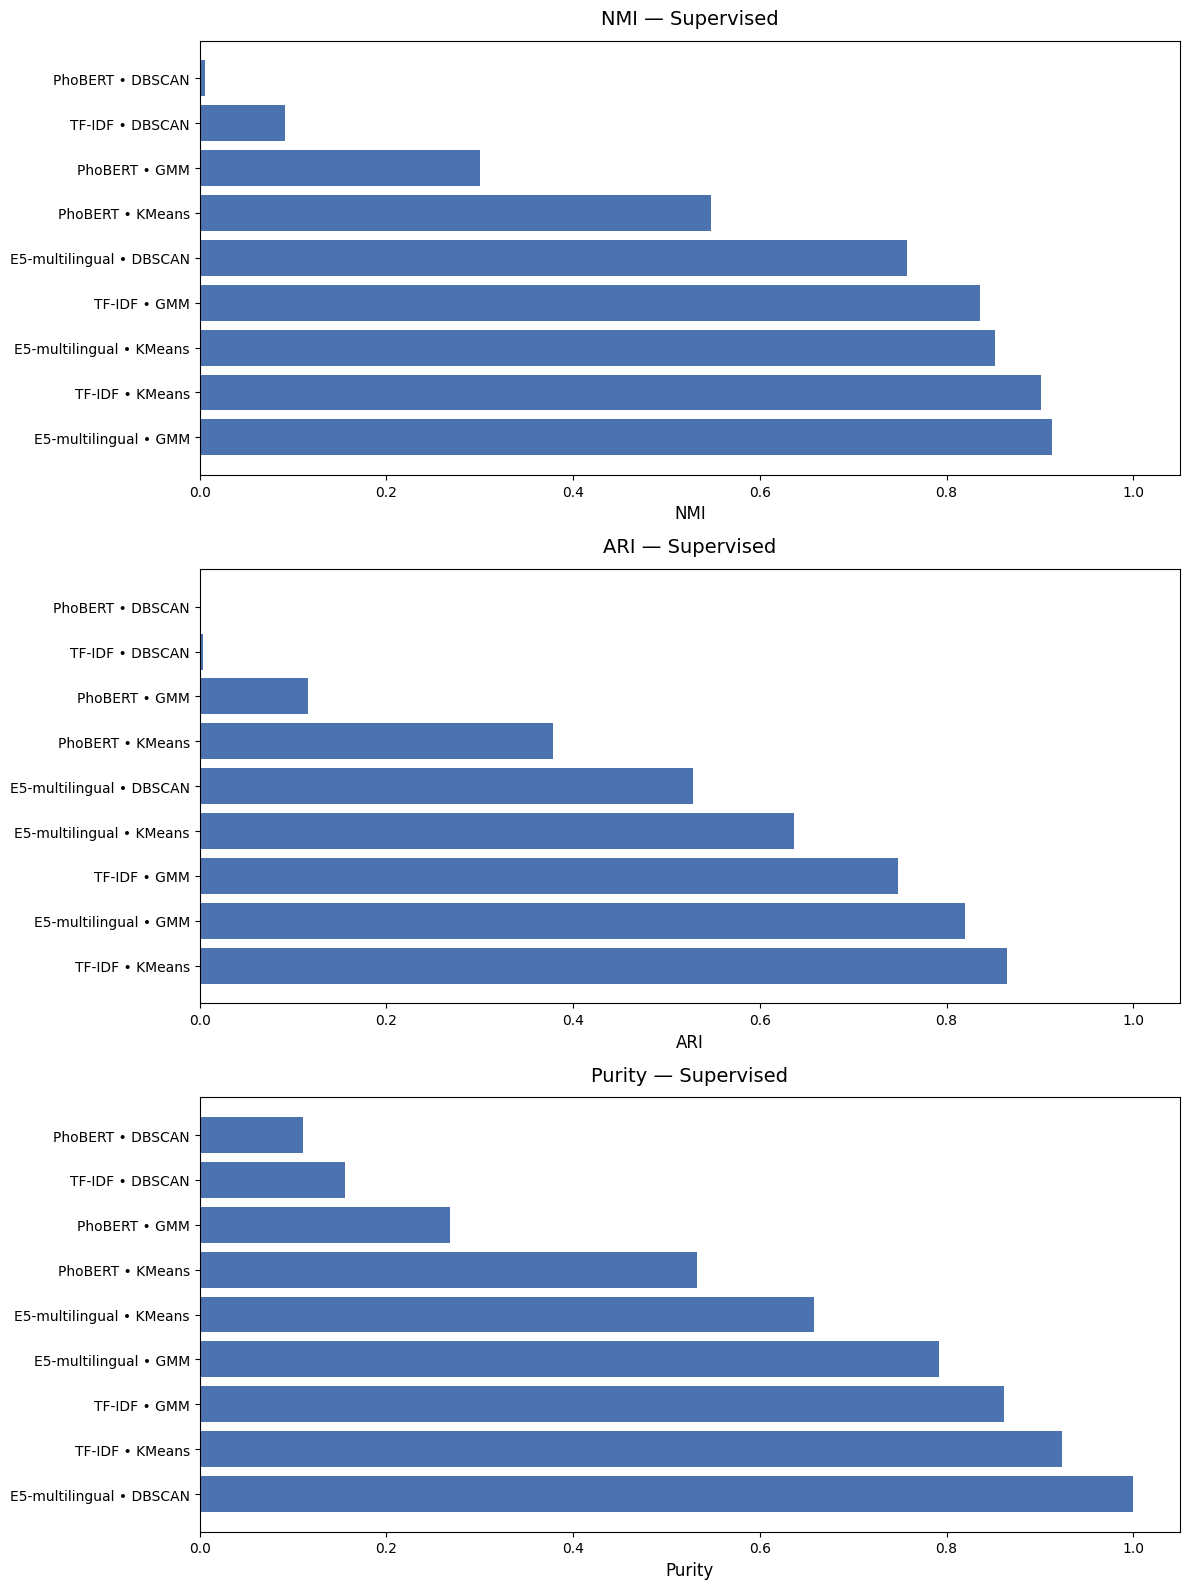

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# ====== DỮ LIỆU CÓ GIÁM SÁT ======
sup_rows = [
    ("TF-IDF",         "KMeans",   0.9016, 0.8642, 0.9238),
    ("TF-IDF",         "DBSCAN",   0.0917, 0.0031, 0.1561),
    ("TF-IDF",         "GMM",      0.8353, 0.7479, 0.8617),
    ("PhoBERT",        "KMeans",   0.5477, 0.3781, 0.5329),
    ("PhoBERT",        "DBSCAN",   0.0058, 0.0006, 0.1107),
    ("PhoBERT",        "GMM",      0.2999, 0.1164, 0.2683),
    ("E5-multilingual","KMeans",   0.8515, 0.6364, 0.6579),
    ("E5-multilingual","DBSCAN",   0.7577, 0.5280, 1.0000),
    ("E5-multilingual","GMM",      0.9128, 0.8199, 0.7922),
]

df_sup = pd.DataFrame(sup_rows, columns=["Embedding","Algorithm","NMI","ARI","Purity"])
df_sup["Label"] = df_sup["Embedding"] + " • " + df_sup["Algorithm"]

def plot_barh_sorted(ax, df, value_col, title, xlabel=None):
    d = df.sort_values(value_col, ascending=False)
    ax.barh(d["Label"], d[value_col], color="#4C72B0")
    ax.set_title(title, fontsize=14, pad=12)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=12)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(0, 1.05)  # các metric ∈ [0,1]

# ====== 1 FIGURE, 3 SUBPLOTS ======
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 16))
plt.subplots_adjust(hspace=0.5)

plot_barh_sorted(
    axes[0], df_sup, "NMI",
    "NMI — Supervised", xlabel="NMI"
)
plot_barh_sorted(
    axes[1], df_sup, "ARI",
    "ARI — Supervised", xlabel="ARI"
)
plot_barh_sorted(
    axes[2], df_sup, "Purity",
    "Purity — Supervised", xlabel="Purity"
)

plt.tight_layout()
plt.show()